## This notebook implements the C2FF method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table, parameter_count

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Function to downsample an image by a given factor
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image

# Function to downsample an image to a reference shape
def downsample_to_shape(image, target_height, target_width):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Initialize a list to hold the resized channels
    resized_channels = []

    # Resize each channel individually
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        resized_channel = cv2.resize(channel, (target_width, target_height), interpolation=cv2.INTER_AREA)
        resized_channels.append(resized_channel)

    # Stack the resized channels back together
    resized_image = np.stack(resized_channels, axis=-1)

    return resized_image

# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

In [4]:
band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)

In [5]:
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [7]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [9]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [10]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_image = normalize(hsi_patch_1)
RGB_1_image = normalize(rgb_patch_1)

In [11]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_image = normalize(hsi_patch_2)
RGB_2_image = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


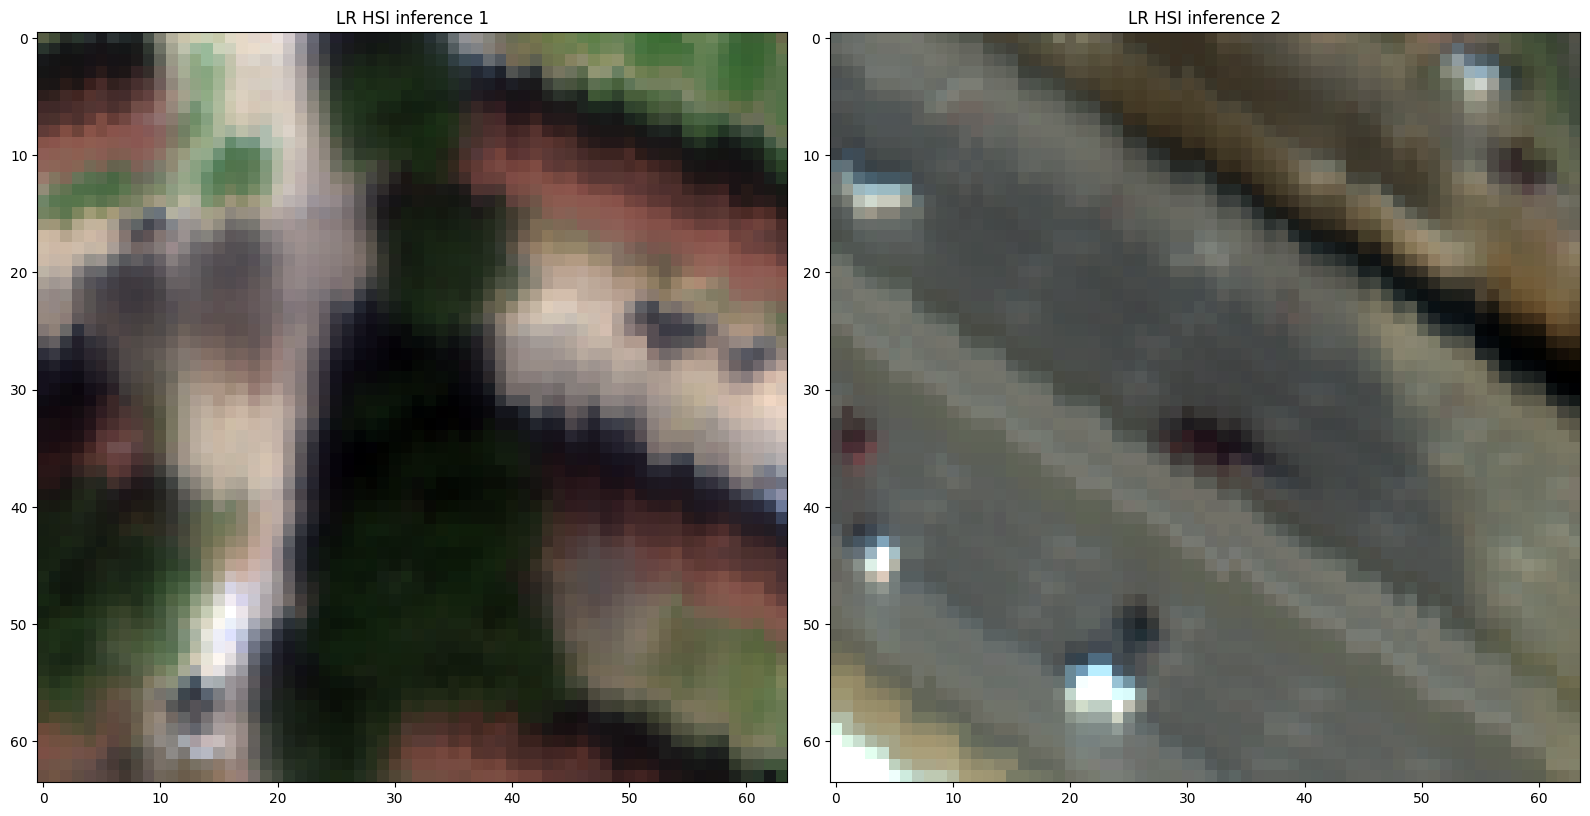

In [12]:
LR_HSI_test_1 = hsi_1_image
print("UH Hyperspectral image 1 inference shape: ", hsi_1_image.shape)

LR_HSI_test_2 = hsi_2_image
print("UH Hyperspectral image 2 inference shape: ", hsi_1_image.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


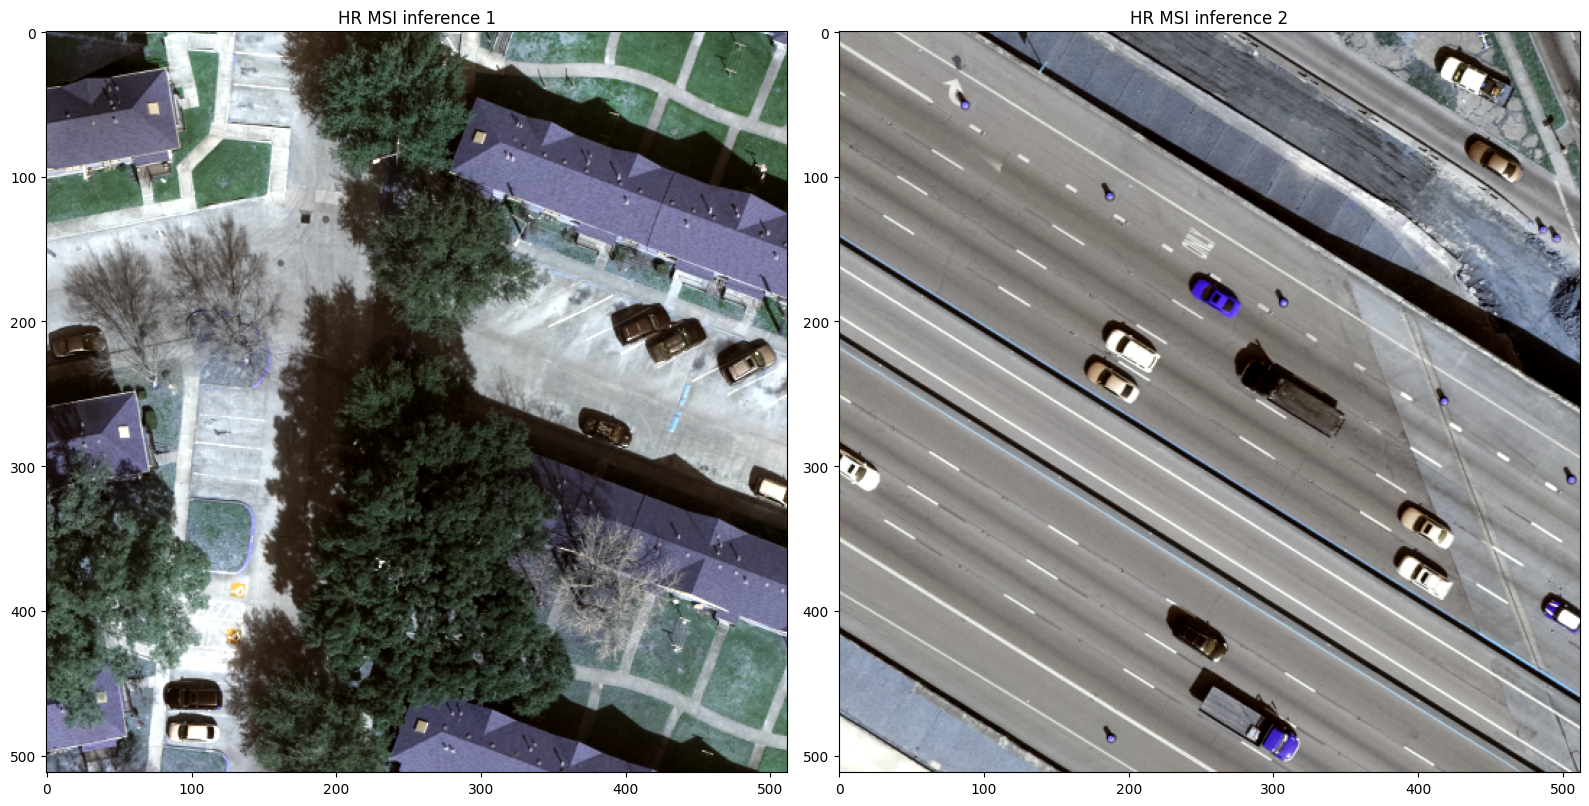

In [13]:
HR_MSI_test_1 = RGB_1_image
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_image
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

C2FF: Model Guided Coarse to Fine Fusion Network for Unsupervised Hyperspectral Image Super Resolution implementation from their GitHub

In [14]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [15]:
class SimpleConfig:
    def __init__(self):
        # Stage 1 (blind estimation) hyperparams
        self.lr_stage1      = 1e-3
        self.niter1         = 3000
        self.niter_decay1   = 3000

        # Stage-2 training (C2F) hyperparams
        self.niter2_SPe = 2000
        self.niter_decay2_SPe = 2000
        self.lr_stage2_SPe = 4e-3

        # Basic data specs
        self.scale_factor = 8    # e.g. how much we downsample from HR to LR
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Optional noise settings
        self.noise = "No"
        self.nSNR  = 35

In [16]:
##############################################################################
# Basic building blocks
##############################################################################

class spectral_res_block(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.one=nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
    def forward(self,input):
        identity_data = input
        output = self.one(input)
        return output + identity_data


class refinement(nn.Module):
    def __init__(self, input_channel, output_channel, block_num):
        super().__init__()
        middle = 30
        self.begin = nn.Conv2d(in_channels=input_channel, out_channels=middle, kernel_size=1, stride=1)
        layers = []
        for _ in range(block_num):
            layers.append(spectral_res_block(middle))
        self.middle = nn.Sequential(*layers)
        self.end = nn.Conv2d(in_channels=middle, out_channels=output_channel, kernel_size=1, stride=1)

    def forward(self,input):
        output1 = self.begin(input)
        output2 = self.middle(output1)
        output3 = self.end(output2)
        return output3


class MSAF(nn.Module):
    """
    Multi-Scale Attention Fusion for fusing two LR MSI estimates.
    """
    def __init__(self, input_channel):
        super().__init__()
        self.three=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(inplace=True)
        )
        self.five=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,5), stride=1, padding=(0,2)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(5,1), stride=1, padding=(2,0)),
            nn.ReLU(inplace=True)
        )
        self.seven=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=(1,7), stride=1, padding=(0,3)),
            nn.Conv2d(input_channel, input_channel, kernel_size=(7,1), stride=1, padding=(3,0)),
            nn.ReLU(inplace=True)
        )
        self.point_wise1=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise2=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise3=nn.Sequential(
            nn.Conv2d(input_channel*2, input_channel, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.point_wise4=nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, lr_msi_fhsi, lr_msi_fmsi):
        """
        lr_msi_fhsi, lr_msi_fmsi: shape (1, MS_bands, H_lr, W_lr)
        """
        input_ = lr_msi_fhsi + lr_msi_fmsi
        scale3 = self.three(input_)
        scale5 = self.five(input_)
        scale7 = self.seven(input_)
        pair_35 = torch.cat([scale3, scale5], dim=1)
        pair_57 = torch.cat([scale5, scale7], dim=1)
        pair_37 = torch.cat([scale3, scale7], dim=1)

        out_wise1 = self.point_wise1(pair_35)
        out_wise2 = self.point_wise2(pair_37)
        out_wise3 = self.point_wise3(pair_57)

        spectral_1 = nn.AdaptiveAvgPool2d(1)(out_wise1) + nn.AdaptiveMaxPool2d(1)(out_wise1)
        spectral_2 = nn.AdaptiveAvgPool2d(1)(out_wise2) + nn.AdaptiveMaxPool2d(1)(out_wise2)
        spectral_3 = nn.AdaptiveAvgPool2d(1)(out_wise3) + nn.AdaptiveMaxPool2d(1)(out_wise3)

        spectral_sum = spectral_1 + spectral_2 + spectral_3
        W = self.point_wise4(spectral_sum)

        fused_lr_msi = W * lr_msi_fhsi + (1.0 - W) * lr_msi_fmsi
        return fused_lr_msi, W


class SDG(nn.Module):
    """
    A small sub-network that projects from 1 MSI band to multiple HS bands.
    """
    def __init__(self, input_channel, output_channel):
        super().__init__()
        middle = 5
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=middle, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=middle, out_channels=output_channel, kernel_size=1, stride=1)
        )
    def forward(self, x):
        return self.conv(x)


In [17]:
class SpectralSRWrapper(nn.Module):
    def __init__(self, subnets, refinement):
        super().__init__()
        self.subnets = nn.ModuleList(subnets)
        self.refinement = refinement

    def forward(self, hr_msi):
        B, ms_band, H, W = hr_msi.shape
        hs_band = self.subnets[0].conv[-1].out_channels  # infer from final conv
        hr_hsi_est_srf = torch.zeros((B, hs_band, H, W), device=hr_msi.device)
        for i in range(ms_band):
            in_i = hr_msi[:, i:i+1, :, :]  # (B, 1, H, W)
            out_i = self.subnets[i](in_i)  # (B, HS, H, W)
            hr_hsi_est_srf += out_i / float(ms_band)
        return self.refinement(hr_hsi_est_srf)

In [18]:
##############################################################################
# The "C2F" stage
# Fuses the two LR MSIs, trains sub-networks to up-project them,
# refines that to produce a "super-resolved" HSI from the HR MSI,
# but does not rely on ground-truth HSI for a final metric.
##############################################################################

class spectral_SR:
    def __init__(self, args,
                 lr_msi_fhsi, lr_msi_fmsi,  # (1, MS_bands, H_lr, W_lr)
                 lr_hsi, hr_msi,            # (1, HS_bands, H_lr, W_lr), (1, MS_bands, H_hr, W_hr)
                 lr_msi_gt=None):
        """
        We do not require the ground-truth HSI here, so `gt_np` was removed.
        """
        self.args = args
        self.lr_msi_fhsi = lr_msi_fhsi
        self.lr_msi_fmsi = lr_msi_fmsi
        self.lr_hsi = lr_hsi
        self.hr_msi = hr_msi

        self.hs_band = lr_hsi.shape[1]
        self.ms_band = lr_msi_fhsi.shape[1]

        # Networks
        self.msaf = MSAF(self.ms_band).to(self.args.device)
        self.refinement = refinement(self.hs_band, self.hs_band, block_num=1).to(self.args.device)

        # We'll create a sub-network for each MSI band that projects 1 channel => self.hs_band
        self.subnets = []
        self.optimizers = []
        self.schedulers = []

        # MSAF optimizer
        opt_fusion = optim.Adam(self.msaf.parameters(), lr=self.args.lr_stage2_SPe)
        def lambda_rule2(epoch):
            total = self.args.niter2_SPe + self.args.niter_decay2_SPe
            lr_l = 1.0 - max(0, epoch+1 - self.args.niter2_SPe)/float(self.args.niter_decay2_SPe+1)
            return lr_l
        sch_fusion = lr_scheduler.LambdaLR(opt_fusion, lr_lambda=lambda_rule2)
        self.optimizers.append(opt_fusion)
        self.schedulers.append(sch_fusion)

        # subnets
        for _ in range(self.ms_band):
            net_i = SDG(1, self.hs_band).to(self.args.device)
            opt_i = optim.Adam(net_i.parameters(), lr=self.args.lr_stage2_SPe)
            sch_i = lr_scheduler.LambdaLR(opt_i, lr_lambda=lambda_rule2)
            self.subnets.append(net_i)
            self.optimizers.append(opt_i)
            self.schedulers.append(sch_i)

        # refinement
        opt_refine = optim.Adam(self.refinement.parameters(), lr=self.args.lr_stage2_SPe)
        sch_refine = lr_scheduler.LambdaLR(opt_refine, lr_lambda=lambda_rule2)
        self.optimizers.append(opt_refine)
        self.schedulers.append(sch_refine)

        self.L1Loss = nn.L1Loss().to(self.args.device)

    def train(self):
        """
        Stage-2 trains so that the fused LR HSI approximates the real LR HSI.
        """
        num_epochs = self.args.niter2_SPe + self.args.niter_decay2_SPe
        t_start = time.perf_counter()

        # Use tqdm for the epoch loop
        pbar = tqdm(range(1, num_epochs + 1), desc="C2F Training", dynamic_ncols=True)
        for epoch in pbar:
            # Zero gradients
            for opt in self.optimizers:
                opt.zero_grad()

            # 1) Fuse the two LR MSIs
            fused_lr_msi, _ = self.msaf(self.lr_msi_fhsi, self.lr_msi_fmsi)

            # 2) Build an LR HSI estimate by processing each MSI band via its subnet
            lr_hsi_est_srf = torch.zeros_like(self.lr_hsi)
            for i in range(self.ms_band):
                in_i = fused_lr_msi[:, i:i+1, :, :]  # (1, 1, H_lr, W_lr)
                out_i = self.subnets[i](in_i)          # (1, HS_bands, H_lr, W_lr)
                lr_hsi_est_srf += out_i / float(self.ms_band)

            # 3) Refine
            lr_hsi_est = self.refinement(lr_hsi_est_srf)

            # 4) Compute L1 loss w.r.t. real LR HSI
            loss_lr = self.L1Loss(lr_hsi_est, self.lr_hsi)
            loss_lr.backward()

            # Optimizer step
            for opt in self.optimizers:
                opt.step()
            for sch in self.schedulers:
                sch.step()

            # Update progress bar with current loss
            pbar.set_postfix({'loss': f"{loss_lr.item():.4f}"})
        pbar.close()
        train_time = time.perf_counter() - t_start
        print(f"Train_all done in {train_time:.2f}s")
    
    def get_super_resolved(self):
        """
        Obtain the final super-resolved HSI as a NumPy array.
        Also compute and print model metrics: number of parameters, FLOPs, GPU memory consumed, and inference time.
        """
        self.msaf.eval()
        self.refinement.eval()
        for net in self.subnets:
            net.eval()
        device = self.args.device

        # -------- FLOPs & Param Count (full model) --------
        wrapper_model = SpectralSRWrapper(self.subnets, self.refinement).to(device)
        inputs = (self.hr_msi.to(device), )
        flops_total, _ = get_flops_fvcore(wrapper_model, inputs)
        param_counts = parameter_count(wrapper_model)
        total_params = sum(param_counts.values())

        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)

        with torch.no_grad():
            start_time = time.time()
            hr_hsi_est = wrapper_model(self.hr_msi.to(device))
            end_time = time.time()
        
        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory

        # Convert output: (1, HS_bands, H_hr, W_hr) -> (H_hr, W_hr, HS_bands)
        X_np = hr_hsi_est[0].cpu().numpy().transpose(1, 2, 0)

        # Print metrics
        print(f"Number of parameters: {total_params}")
        print(f"FLOPs: {flops_total}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")
        
        return X_np

In [19]:
class BlurDown(object):
    """Apply a shared PSF via grouped conv with stride=ratio."""
    def __init__(self):
        pass

    def __call__(self, input_tensor: torch.Tensor, psf: torch.Tensor,
                 groups: int, ratio: int) -> torch.Tensor:
        # psf: (1,1,K,K) but conv2d needs (groups,1,K,K)
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        return F.conv2d(input_tensor, psf, bias=None,
                        stride=(ratio, ratio), groups=groups)

class BlindNet(nn.Module):
    """
    Learns a PSF (1×1→K×K) and SRF (hs_bands→ms_bands via 1×1),
    then applies them to (lr_hsi, hr_msi) to produce two Lr‑MSI estimates.
    """
    def __init__(self, hs_bands: int, ms_bands: int,
                 ker_size: int, ratio: int):
        super().__init__()
        # initialize PSF to uniform K×K
        self.psf = nn.Parameter(torch.ones(1,1,ker_size,ker_size) / (ker_size**2))
        # initialize SRF to uniform mapping (ms_bands × hs_bands)
        self.srf = nn.Parameter(torch.ones(ms_bands, hs_bands,1,1) / hs_bands)
        self.blur_down = BlurDown()
        self.ratio = ratio
        self.ms_bands = ms_bands

    def forward(self,
                lr_hsi: torch.Tensor,   # (1, hs_bands, H_lr, W_lr)
                hr_msi: torch.Tensor    # (1, ms_bands, H_hr, W_hr)
               ):
        # ---- spectral response (SRF) branch ----
        # normalize each SRF row so it sums to 1
        srf = self.srf.clamp(min=0.0)                        # ≥0
        div = srf.sum(dim=1, keepdim=True)                   # (ms,1,1,1)
        srf = srf / (div + 1e-8)

        # apply SRF: conv1x1 over HSI bands → ms_bands channels
        lr_msi_fhsi = F.conv2d(lr_hsi, srf, bias=None)       # (1, ms_bands, H_lr, W_lr)
        lr_msi_fhsi = lr_msi_fhsi.clamp(0.0, 1.0)

        # ---- point‑spread function (PSF) branch ----
        # convolve and downsample HR MSI
        psf = self.psf.clamp(min=0.0)                        # ≥0
        psf = psf / (psf.sum() + 1e-8)                       # sum to 1
        lr_msi_fmsi = self.blur_down(hr_msi, psf,
                                     groups=self.ms_bands,
                                     ratio=self.ratio)
        lr_msi_fmsi = lr_msi_fmsi.clamp(0.0, 1.0)

        return lr_msi_fhsi, lr_msi_fmsi

In [20]:
def run_pipeline(args, I_LR_HSI, I_HR_MSI, downsample_factor):
    """
    1) Stage‑1: blind PSF/SRF estimation (with tqdm)
    2) Stage‑2: C2F super‑resolution
    Returns: (SR_image, psf_est, srf_est)
    """
    device = args.device

    # 0) To tensors
    lr_hsi_t = torch.from_numpy(I_LR_HSI.transpose(2,0,1))\
                      .unsqueeze(0).float().to(device)
    hr_msi_t = torch.from_numpy(I_HR_MSI.transpose(2,0,1))\
                      .unsqueeze(0).float().to(device)

    hs_bands, ms_bands = lr_hsi_t.size(1), hr_msi_t.size(1)
    n_epochs = args.niter1 + args.niter_decay1

    # 1) Stage‑1: Blind estimation
    blind_net = BlindNet(hs_bands, ms_bands,
                         ker_size=downsample_factor,
                         ratio=downsample_factor)\
                    .to(device)
    opt1   = torch.optim.Adam(blind_net.parameters(), lr=args.lr_stage1)
    sched1 = torch.optim.lr_scheduler.LambdaLR(
        opt1,
        lambda e: 1.0 - max(0, e+1 - args.niter1)/float(args.niter_decay1 + 1)
    )
    
    # Counting the number of parameters in blindnet
    num_params = sum(p.numel() for p in blind_net.parameters() if p.requires_grad)
    
    # Measuring the FLOPs of blindnet
    flops_analyzer = FlopCountAnalysis(blind_net, (lr_hsi_t, hr_msi_t))
    flops_blind    = flops_analyzer.total()

    print(f"Total parameters in blind model: {num_params:,}")
    print(f"Total FLOPs (1× forward): {flops_blind:,}")

    # Measuring the time and GPU memory consumed by the blind part
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    
    pbar = tqdm(range(n_epochs), desc="Stage‑1 Blind", leave=True)
    for epoch in pbar:
        opt1.zero_grad()
        est_fhsi_t, est_fmsi_t = blind_net(lr_hsi_t, hr_msi_t)
        loss1 = (est_fhsi_t - est_fmsi_t).abs().sum()
        loss1.backward()
        opt1.step()
        sched1.step()

        pbar.set_postfix(loss=f"{loss1.item():.4e}")
        
    peak_bytes = torch.cuda.max_memory_allocated(device)
    peak_mb    = peak_bytes / 1024**2

    end_time = time.time()
    print(f"Blind training took {end_time - start_time:.1f}s")
    print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

    # grab learned PSF & SRF
    psf_est = blind_net.psf.detach().cpu().numpy()[0,0]                                     # (K, K)
    # srf: (ms_bands, hs_bands,1,1) → (hs_bands, ms_bands)
    srf_est = blind_net.srf.detach().cpu().numpy().reshape(ms_bands, hs_bands)
    
    # Plotting the estimated PSF and SRF
    plot_psf_srf(psf_est, srf_est)
    
    # detach before Stage‑2
    lr_msi_fmsi_est_t = est_fmsi_t.detach()

    # Since the SRF produced by the blind method is not very good, we will use the RGB SRF for IKONOs
    lr_msi_fhsi_est, srf, _ = apply_srf(I_LR_HSI, band_specs, fwhm_factor=4.3)
    lr_msi_fhsi_est_t = torch.from_numpy(lr_msi_fhsi_est.transpose(2,0,1)).unsqueeze(0).float().to(device)
    
    # 2) Stage‑2: C2F Super‑Resolution
    C2F = spectral_SR(
        args,
        lr_msi_fhsi_est_t,   # (1,ms_bands,H_lr,W_lr)
        lr_msi_fmsi_est_t,   # (1,ms_bands,H_lr,W_lr)
        lr_hsi_t,
        hr_msi_t
    )
    C2F.train()
    SR_image_t = C2F.get_super_resolved()  # (1,hs_bands,H_hr,W_hr)

    return SR_image_t

In [21]:
def plot_psf_srf(psf_est, srf_est):
    """
    Plot PSF as heatmap and SRF as curves.

    Args:
        psf_est: (kH, kW) numpy array
        srf_est: (ms_bands, hs_bands) numpy array
    """
    ms_bands, hs_bands = srf_est.shape

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot PSF ---
    ax = axs[0]
    im = ax.imshow(psf_est, cmap='viridis')
    ax.set_title('Estimated PSF')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # --- Plot SRF ---
    ax = axs[1]
    x = np.arange(hs_bands)
    for i in range(ms_bands):
        ax.plot(x, srf_est[i], label=f'MSI Band {i+1}')
    ax.set_title('Estimated SRF (Spectral Curves)')
    ax.set_xlabel('HSI Band Index')
    ax.set_ylabel('Relative Response')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [23]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/C2FF"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_c2ff_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_c2ff_folder_path):
    os.makedirs(uh_c2ff_folder_path)

Super resolving UH image 1 

Unsupported operator aten::sum encountered 2 time(s)
Unsupported operator aten::add encountered 2 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 214
Total FLOPs (1× forward): 1,400,832


Stage‑1 Blind: 100%|██████████| 6000/6000 [03:06<00:00, 32.12it/s, loss=1.6689e+03]


Blind training took 186.9s
Peak GPU memory during training: 7.0 MB


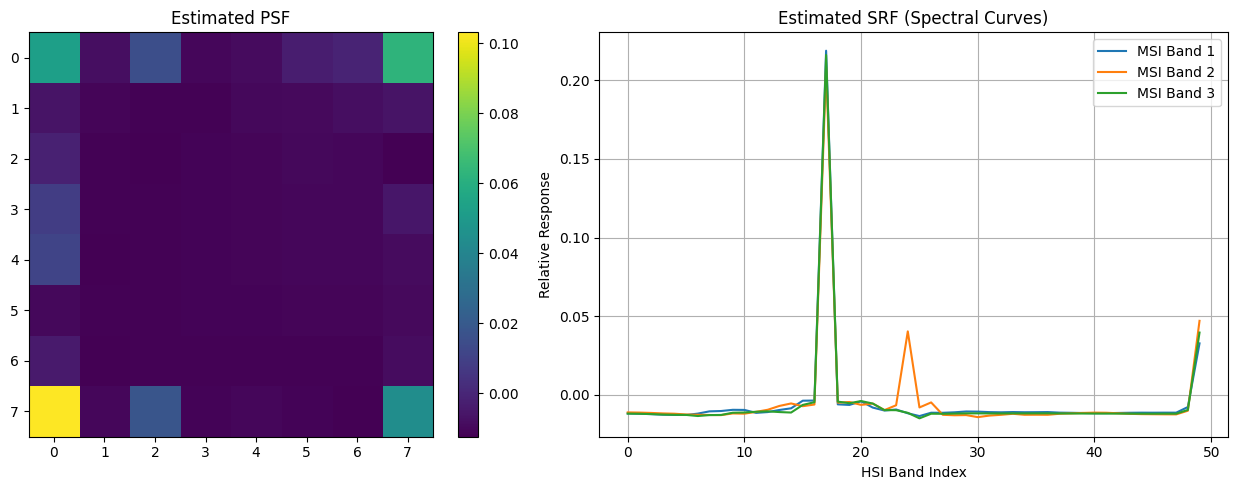

C2F Training: 100%|██████████| 10000/10000 [12:15<00:00, 13.59it/s, loss=0.0065]


Train_all done in 735.82s


Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Number of parameters: 30920
FLOPs: 1458831360
GPU memory consumed: 210.00 MB
Inference time: 0.0270 seconds
Final SR image shape: (512, 512, 50)
SR image max: 1.5177735
SR image min: -0.020138774
SR image mean: 0.39239654
Saved SR HSI 1 at location specified in uh_c2ff_folder_path


In [24]:
args = SimpleConfig()

# Stage‑1 (blind PSF/SRF)
args.lr_stage1      = 0.001
args.niter1         = 3000
args.niter_decay1   = 3000

# Stage 2 (C2FF)
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image_1 = run_pipeline(args, LR_HSI_test_1, HR_MSI_test_1, 8)

print("Final SR image shape:", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_c2ff_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved SR HSI 1 at location specified in uh_c2ff_folder_path")

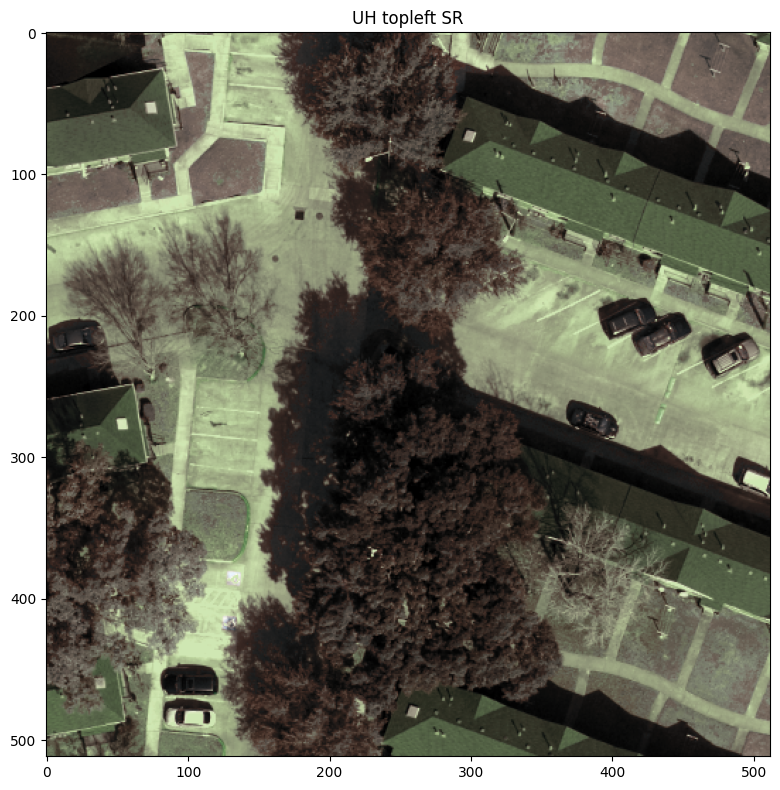

In [25]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

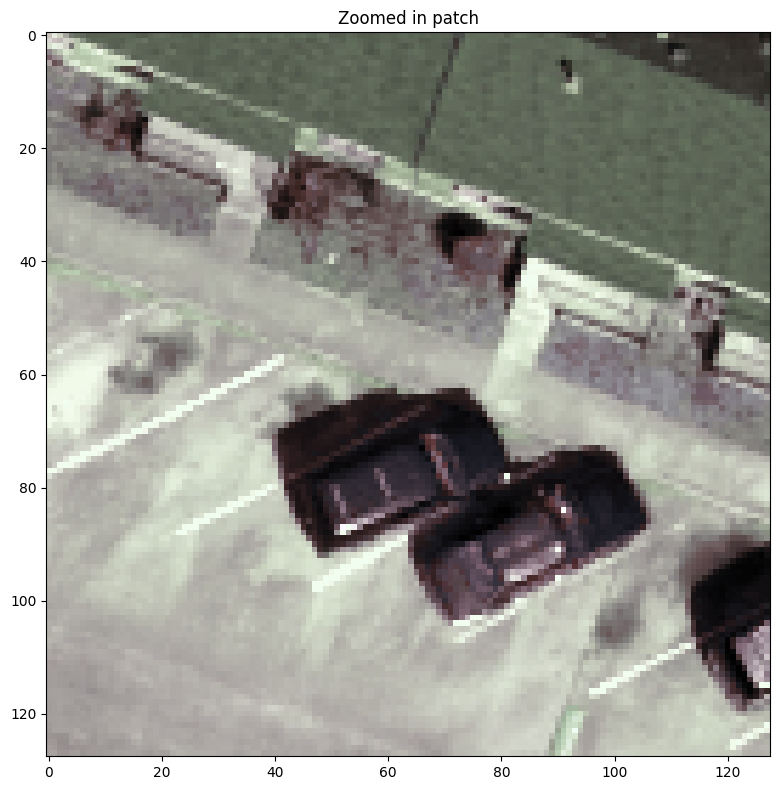

In [26]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

Unsupported operator aten::sum encountered 2 time(s)
Unsupported operator aten::add encountered 2 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 214
Total FLOPs (1× forward): 1,400,832


Stage‑1 Blind: 100%|██████████| 6000/6000 [02:07<00:00, 47.21it/s, loss=7.7595e+02]


Blind training took 127.1s
Peak GPU memory during training: 7.0 MB


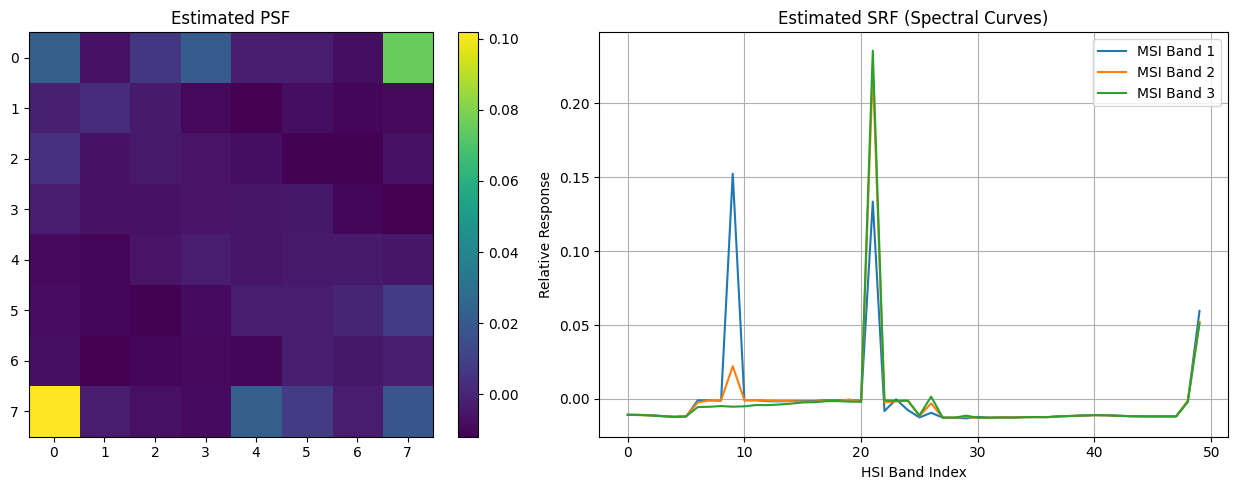

C2F Training: 100%|██████████| 10000/10000 [10:06<00:00, 16.50it/s, loss=0.0059]


Train_all done in 606.11s


Unsupported operator aten::div encountered 3 time(s)
Unsupported operator aten::add_ encountered 3 time(s)
Unsupported operator aten::add encountered 1 time(s)


Number of parameters: 30920
FLOPs: 1458831360
GPU memory consumed: 210.00 MB
Inference time: 0.0119 seconds
Final SR image shape: (512, 512, 50)
SR image max: 1.0647534
SR image min: -0.1201204
SR image mean: 0.43257576
Saved SR HSI 2 at location specified in uh_c2ff_folder_path


In [27]:
args = SimpleConfig()

# Stage‑1 (blind PSF/SRF)
args.lr_stage1      = 0.001
args.niter1         = 3000
args.niter_decay1   = 3000

# Stage 2 (C2FF)
args.scale_factor = 8   # e.g. must match H_hr/H_lr
args.niter2_SPe = 5000
args.niter_decay2_SPe = 5000
args.lr_stage2_SPe = 4e-3

# Run pipeline
SR_image_2 = run_pipeline(args, LR_HSI_test_2, HR_MSI_test_2, 8)

print("Final SR image shape:", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_c2ff_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved SR HSI 2 at location specified in uh_c2ff_folder_path")

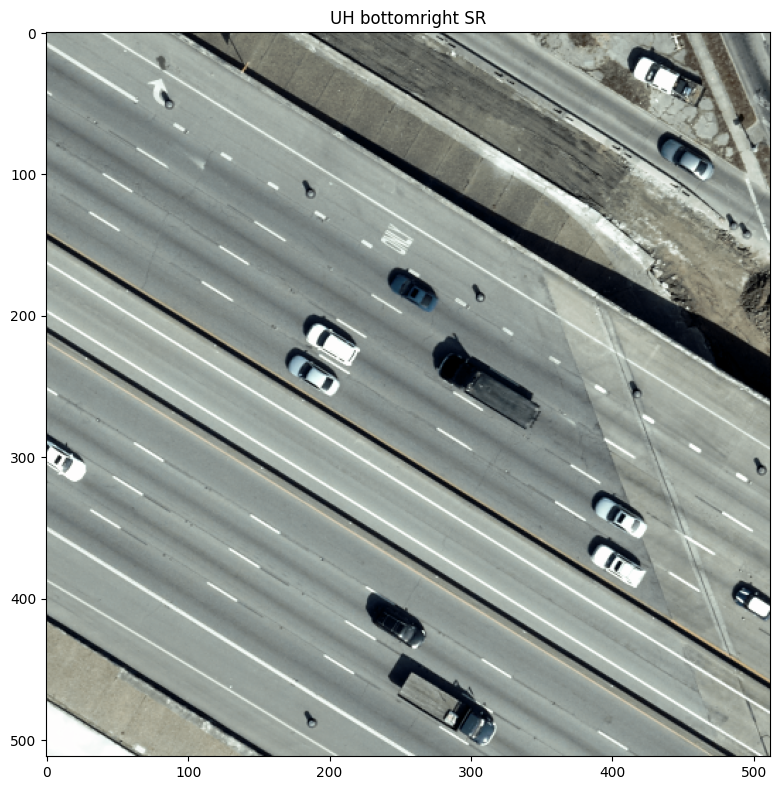

In [28]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

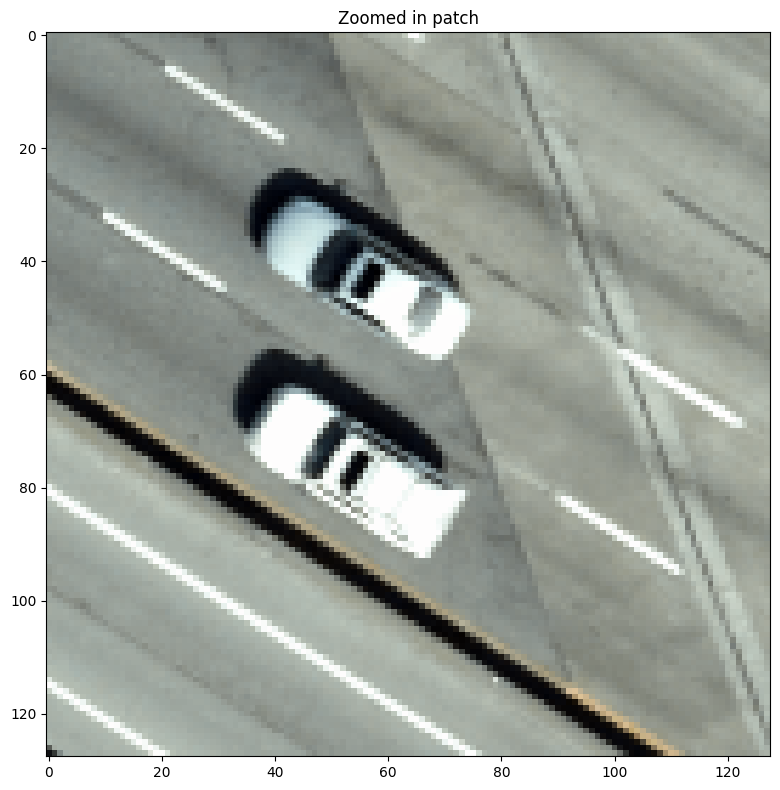

In [29]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")